# ML-Based Solar Plant Monitoring System

**Plant**: HKL (GGI) - 269.28 kWp

## Approach:
Instead of comparing to theoretical clear-sky production, we train a machine learning model on **historical data** to learn:
- How the plant performs under various weather conditions
- Seasonal patterns
- Temperature effects
- Normal production ranges

Then we use the model to **predict expected production** for current conditions and flag **genuine anomalies** when actual production significantly deviates from the learned pattern.

## Why This Works Better:
✅ Accounts for actual weather (clouds, rain, etc.)
✅ Learns plant-specific behavior
✅ Only flags REAL problems (equipment failure, soiling, shading)
✅ Not fooled by normal cloudy days

## Pipeline:
1. **Load & Clean Data** - Prepare historical data
2. **Feature Engineering** - Create ML features from weather, time, solar position
3. **Train Model** - Learn production patterns
4. **Validate** - Time series cross-validation
5. **Monitor** - Detect anomalies in new data
6. **Report** - Daily monitoring dashboard

In [1]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings

# Solar
import pvlib
from pvlib.location import Location

# Machine Learning
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Environment
from dotenv import load_dotenv
import os

# Config
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100
pd.set_option('display.max_columns', None)

load_dotenv()
ow_key = os.getenv('ow_key')

print("✓ Imports loaded")

✓ Imports loaded


## Configuration

In [2]:
# Plant configuration
PLANT_CONFIG = {
    'name': 'HKL (GGI)',
    'capacity_kwp': 269.28,
    'latitude': 24.022350694140282,
    'longitude': 90.29576719011767,
    'timezone': 'Asia/Dhaka'
}

# ML Configuration
ML_CONFIG = {
    'target_frequency': '1H',  # Hourly predictions
    'train_test_split_date': '2024-09-01',  # Train on data before this, test after
    'min_sun_elevation': 5,  # Only predict when sun is up
    'n_cv_splits': 5,  # Time series cross-validation splits
    'anomaly_threshold_std': 2.5,  # Flag if residual > 2.5 std deviations
}

# File paths
DATA_PATHS = {
    'inverter_plants': 'data/inverter_plants.csv',
    'generation_5m': 'data/inverter_five_minutes_generation_logs.csv',
    'weather': 'open_data/gazipur_weather.csv'
}

print("✓ Configuration set")

✓ Configuration set


---
## Step 1: Data Loading & Preparation
Load and prepare all data sources

In [3]:
def load_and_prepare_data():
    """
    Load all data and prepare for ML training.
    Returns hourly dataframe with all features.
    """
    print("📊 Loading data...")

    # Load plant metadata
    df_plants = pd.read_csv(DATA_PATHS['inverter_plants'])
    df_plants['plant_address'] = df_plants['plant_address'].fillna('Gazipur')

    # Load 5-minute generation data
    df = pd.read_csv(DATA_PATHS['generation_5m'])
    df['generation_date'] = pd.to_datetime(df['generation_date'])

    # Merge plant info
    df = df.merge(
        df_plants[['plant_id', 'plant_name', 'plant_capacity']],
        on='plant_id', how='left'
    )

    # Filter for HKL
    df = df[df['plant_name'] == PLANT_CONFIG['name']].copy()

    # Clean generation amount
    df['generation_amount'] = df['generation_amount'].astype(str).str.replace(',', '').astype(float)
    df['generation_kwh'] = df['generation_amount'] / 1000

    # Timezone
    if df['generation_date'].dt.tz is None:
        df['generation_date'] = df['generation_date'].dt.tz_localize('UTC')
    df['generation_date'] = df['generation_date'].dt.tz_convert(PLANT_CONFIG['timezone'])

    # Filter to 2024 onwards (cleaner data)
    df = df[df['generation_date'] >= '2024-01-01'].copy()

    # Remove duplicates
    df = df.drop_duplicates(subset='generation_date', keep='last')
    df = df.sort_values('generation_date').reset_index(drop=True)

    print(f"  ✓ Loaded {len(df):,} 5-minute records")

    # Resample to hourly
    df_hourly = (
        df.set_index('generation_date')
        .resample('1H')
        .agg({'generation_kwh': 'sum'})
        .reset_index()
    )

    print(f"  ✓ Resampled to {len(df_hourly):,} hourly records")

    # Add solar position
    print("☀️  Calculating solar position...")
    location = Location(
        latitude=PLANT_CONFIG['latitude'],
        longitude=PLANT_CONFIG['longitude'],
        tz=PLANT_CONFIG['timezone']
    )

    times = pd.DatetimeIndex(df_hourly['generation_date'])
    solpos = location.get_solarposition(times)
    clearsky = location.get_clearsky(times)

    df_hourly['elevation'] = solpos['elevation'].values
    df_hourly['azimuth'] = solpos['azimuth'].values
    df_hourly['ghi'] = clearsky['ghi'].values

    print("  ✓ Solar position added")

    # Add weather data
    print("🌤️  Loading weather data...")
    weather = pd.read_csv(DATA_PATHS['weather'])
    weather['generation_date'] = pd.to_datetime(
        weather['dt_iso'].str.replace(' UTC', ''), utc=True
    ).dt.tz_convert(PLANT_CONFIG['timezone'])

    weather = weather[[
        'generation_date', 'temp', 'visibility', 'rain_1h', 'clouds_all'
    ]].groupby('generation_date').agg({
        'temp': 'mean',
        'visibility': 'mean',
        'rain_1h': 'sum',
        'clouds_all': 'mean'
    }).reset_index()

    df_hourly = df_hourly.merge(weather, on='generation_date', how='left')

    # Interpolate missing weather
    df_hourly['temp'] = df_hourly['temp'].interpolate(method='linear', limit_direction='both')
    df_hourly['visibility'] = df_hourly['visibility'].interpolate(method='linear', limit_direction='both')
    df_hourly['clouds_all'] = df_hourly['clouds_all'].interpolate(method='linear', limit_direction='both')
    df_hourly['rain_1h'] = df_hourly['rain_1h'].fillna(0)

    print("  ✓ Weather data merged")

    return df_hourly

# Load data
df_hourly = load_and_prepare_data()
print(f"\n✅ Data preparation complete: {len(df_hourly):,} hours")

📊 Loading data...
  ✓ Loaded 153,567 5-minute records
  ✓ Resampled to 15,862 hourly records
☀️  Calculating solar position...
  ✓ Solar position added
🌤️  Loading weather data...
  ✓ Weather data merged

✅ Data preparation complete: 15,862 hours


---
## Step 2: Feature Engineering
Create features that help the model learn production patterns

In [4]:
def create_ml_features(df):
    """
    Create comprehensive feature set for ML model.

    Features include:
    - Time features (hour, day, month, season)
    - Weather features (temp, clouds, visibility, rain, GHI)
    - Solar position (elevation, azimuth)
    - Lagged features (yesterday's production)
    - Rolling features (7-day average)
    """
    print("\n🔧 Engineering features...")
    df = df.copy()

    # ===== TIME FEATURES =====
    df['hour'] = df['generation_date'].dt.hour
    df['day_of_week'] = df['generation_date'].dt.dayofweek  # 0=Monday, 6=Sunday
    df['day_of_year'] = df['generation_date'].dt.dayofyear
    df['month'] = df['generation_date'].dt.month
    df['week_of_year'] = df['generation_date'].dt.isocalendar().week

    # Cyclical encoding for periodic features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

    # Weekend flag
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

    print("  ✓ Time features created")

    # ===== WEATHER FEATURES =====
    # Already have: temp, visibility, rain_1h, clouds_all

    # Derived weather features
    df['cloud_impact'] = 1 - (df['clouds_all'] / 100)  # 0=full clouds, 1=clear
    df['has_rain'] = (df['rain_1h'] > 0).astype(int)
    df['temp_squared'] = df['temp'] ** 2  # Capture non-linear temp effects

    # Weather-solar interaction
    df['effective_irradiance'] = df['ghi'] * df['cloud_impact']

    print("  ✓ Weather features created")

    # ===== SOLAR FEATURES =====
    # Already have: elevation, azimuth, ghi

    df['is_daytime'] = (df['elevation'] > ML_CONFIG['min_sun_elevation']).astype(int)

    # Sun position bins (morning/noon/afternoon)
    df['sun_period'] = pd.cut(
        df['azimuth'],
        bins=[-np.inf, 90, 180, 270, np.inf],
        labels=['morning', 'late_morning', 'afternoon', 'evening']
    )
    df['sun_period_morning'] = (df['sun_period'] == 'morning').astype(int)
    df['sun_period_late_morning'] = (df['sun_period'] == 'late_morning').astype(int)
    df['sun_period_afternoon'] = (df['sun_period'] == 'afternoon').astype(int)

    print("  ✓ Solar features created")

    # ===== LAGGED FEATURES =====
    # Production from previous periods (helps capture degradation, maintenance)
    for lag in [24, 48, 168]:  # 1 day ago, 2 days ago, 1 week ago
        df[f'production_lag_{lag}h'] = df['generation_kwh'].shift(lag)

    print("  ✓ Lagged features created")

    # ===== ROLLING FEATURES =====
    # Average production over past week (at same hour)
    df['production_7d_mean'] = df['generation_kwh'].rolling(window=168, min_periods=24).mean()
    df['production_7d_std'] = df['generation_kwh'].rolling(window=168, min_periods=24).std()

    # Weather trends
    df['temp_7d_mean'] = df['temp'].rolling(window=168, min_periods=24).mean()
    df['clouds_7d_mean'] = df['clouds_all'].rolling(window=168, min_periods=24).mean()

    print("  ✓ Rolling features created")

    # ===== INTERACTION FEATURES =====
    # Combinations that might be predictive
    df['ghi_x_cloud_impact'] = df['ghi'] * df['cloud_impact']
    df['elevation_x_cloud_impact'] = df['elevation'] * df['cloud_impact']

    print("  ✓ Interaction features created")

    n_features = len([col for col in df.columns if col not in ['generation_date', 'generation_kwh']])
    print(f"\n✅ Feature engineering complete: {n_features} features created")

    return df

# Create features
df_features = create_ml_features(df_hourly)


🔧 Engineering features...
  ✓ Time features created
  ✓ Weather features created
  ✓ Solar features created
  ✓ Lagged features created
  ✓ Rolling features created
  ✓ Interaction features created

✅ Feature engineering complete: 35 features created


In [5]:
def prepare_ml_dataset(df):
    """
    Prepare final dataset for ML training.
    - Remove rows with missing target
    - Only include daytime hours
    - Split into train/test
    """
    print("\n📋 Preparing ML dataset...")

    df = df.copy()

    # Only daytime hours (when sun is up)
    df = df[df['is_daytime'] == 1].copy()
    print(f"  → Filtered to daytime: {len(df):,} hours")

    # Remove rows with missing target or key features
    initial_len = len(df)
    df = df.dropna(subset=['generation_kwh'])
    print(f"  → Removed {initial_len - len(df):,} rows with missing target")

    # Define feature columns (exclude target and non-features)
    exclude_cols = [
        'generation_date', 'generation_kwh', 'sun_period',  # Target and identifiers
        'is_daytime'  # Already filtered on this
    ]
    feature_cols = [col for col in df.columns if col not in exclude_cols]

    # Fill remaining NaN in features (from lagged/rolling features)
    df[feature_cols] = df[feature_cols].ffill().bfill().fillna(0)

    print(f"  → Features: {len(feature_cols)}")
    print(f"  → Training samples: {len(df):,}")

    # Split into train/test by date (time series split)
    split_date = pd.Timestamp(ML_CONFIG['train_test_split_date']).tz_localize(PLANT_CONFIG['timezone'])

    train_df = df[df['generation_date'] < split_date].copy()
    test_df = df[df['generation_date'] >= split_date].copy()

    print(f"\n  📊 Train set: {len(train_df):,} samples ({train_df['generation_date'].min().date()} to {train_df['generation_date'].max().date()})")
    print(f"  📊 Test set:  {len(test_df):,} samples ({test_df['generation_date'].min().date()} to {test_df['generation_date'].max().date()})")

    X_train = train_df[feature_cols]
    y_train = train_df['generation_kwh']
    X_test = test_df[feature_cols]
    y_test = test_df['generation_kwh']

    print(f"\n✅ Dataset prepared")

    return X_train, X_test, y_train, y_test, train_df, test_df, feature_cols

# Prepare dataset
X_train, X_test, y_train, y_test, train_df, test_df, feature_cols = prepare_ml_dataset(df_features)


📋 Preparing ML dataset...
  → Filtered to daytime: 7,540 hours
  → Removed 0 rows with missing target
  → Features: 33
  → Training samples: 7,540

  📊 Train set: 2,864 samples (2024-01-01 to 2024-08-31)
  📊 Test set:  4,676 samples (2024-09-01 to 2025-10-22)

✅ Dataset prepared


---
## Step 3: Model Training
Train ML model to predict energy production

In [6]:
def train_production_model(X_train, y_train, X_test, y_test):
    """
    Train Random Forest model to predict hourly production.

    Using Random Forest because:
    - Handles non-linear relationships well
    - Robust to outliers
    - Provides feature importance
    - No need for feature scaling
    """
    print("\n🤖 Training ML model...")
    print("  Model: Random Forest Regressor")

    # Initialize model
    model = RandomForestRegressor(
        n_estimators=200,          # Number of trees
        max_depth=20,              # Max tree depth
        min_samples_split=10,      # Min samples to split node
        min_samples_leaf=5,        # Min samples in leaf
        max_features='sqrt',       # Features per split
        random_state=42,
        n_jobs=-1,                 # Use all CPU cores
        verbose=0
    )

    # Train
    print("  → Training on {:,} samples...".format(len(X_train)))
    model.fit(X_train, y_train)
    print("  ✓ Training complete")

    # Predict on train and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)

    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)

    print("\n  📊 Model Performance:")
    print("  " + "="*50)
    print(f"  {'Metric':<20} {'Train':<15} {'Test':<15}")
    print("  " + "-"*50)
    print(f"  {'MAE (kWh)':<20} {train_mae:<15.2f} {test_mae:<15.2f}")
    print(f"  {'RMSE (kWh)':<20} {train_rmse:<15.2f} {test_rmse:<15.2f}")
    print(f"  {'R² Score':<20} {train_r2:<15.3f} {test_r2:<15.3f}")
    print("  " + "="*50)

    # Interpretation
    avg_production = y_test.mean()
    mape = (test_mae / avg_production) * 100
    print(f"\n  → Average production: {avg_production:.1f} kWh/hour")
    print(f"  → MAPE: {mape:.1f}% (Mean Absolute Percentage Error)")

    if test_r2 > 0.9:
        print("  → 🟢 Excellent model performance!")
    elif test_r2 > 0.8:
        print("  → 🟡 Good model performance")
    else:
        print("  → 🟠 Model could be improved")

    print("\n✅ Model training complete")

    return model, y_train_pred, y_test_pred

# Train model
model, y_train_pred, y_test_pred = train_production_model(X_train, y_train, X_test, y_test)


🤖 Training ML model...
  Model: Random Forest Regressor
  → Training on 2,864 samples...
  ✓ Training complete

  📊 Model Performance:
  Metric               Train           Test           
  --------------------------------------------------
  MAE (kWh)            15.54           25.53          
  RMSE (kWh)           21.92           35.33          
  R² Score             0.839           0.548          

  → Average production: 65.0 kWh/hour
  → MAPE: 39.3% (Mean Absolute Percentage Error)
  → 🟠 Model could be improved

✅ Model training complete


### Feature Importance
What features does the model consider most important?

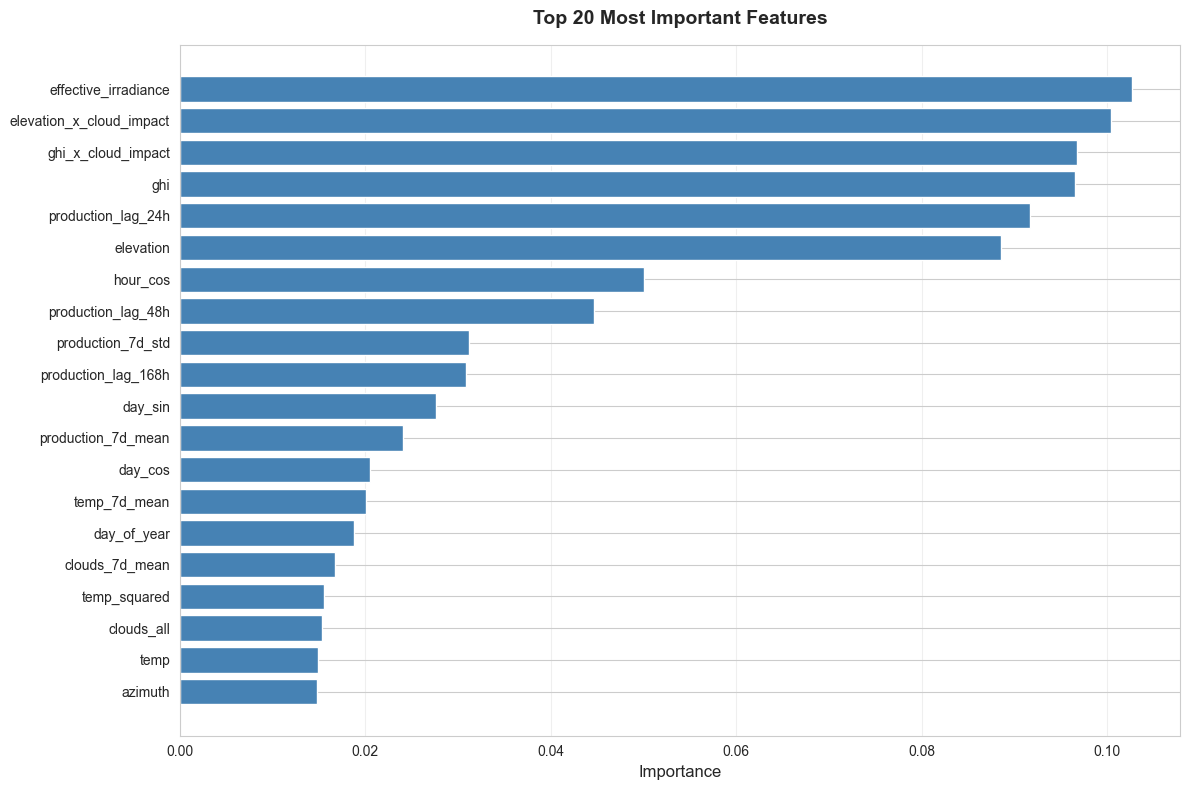


🔍 Top 10 Most Important Features:
                 feature  importance
    effective_irradiance    0.102729
elevation_x_cloud_impact    0.100457
      ghi_x_cloud_impact    0.096789
                     ghi    0.096537
      production_lag_24h    0.091733
               elevation    0.088544
                hour_cos    0.050033
      production_lag_48h    0.044674
       production_7d_std    0.031185
     production_lag_168h    0.030824


In [7]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 features
fig, ax = plt.subplots(figsize=(12, 8))
top_features = feature_importance.head(20)
ax.barh(range(len(top_features)), top_features['importance'], color='steelblue')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.invert_yaxis()
ax.set_xlabel('Importance', fontsize=12)
ax.set_title('Top 20 Most Important Features', fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n🔍 Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

---
## Step 4: Model Validation
Visualize predictions vs actual production

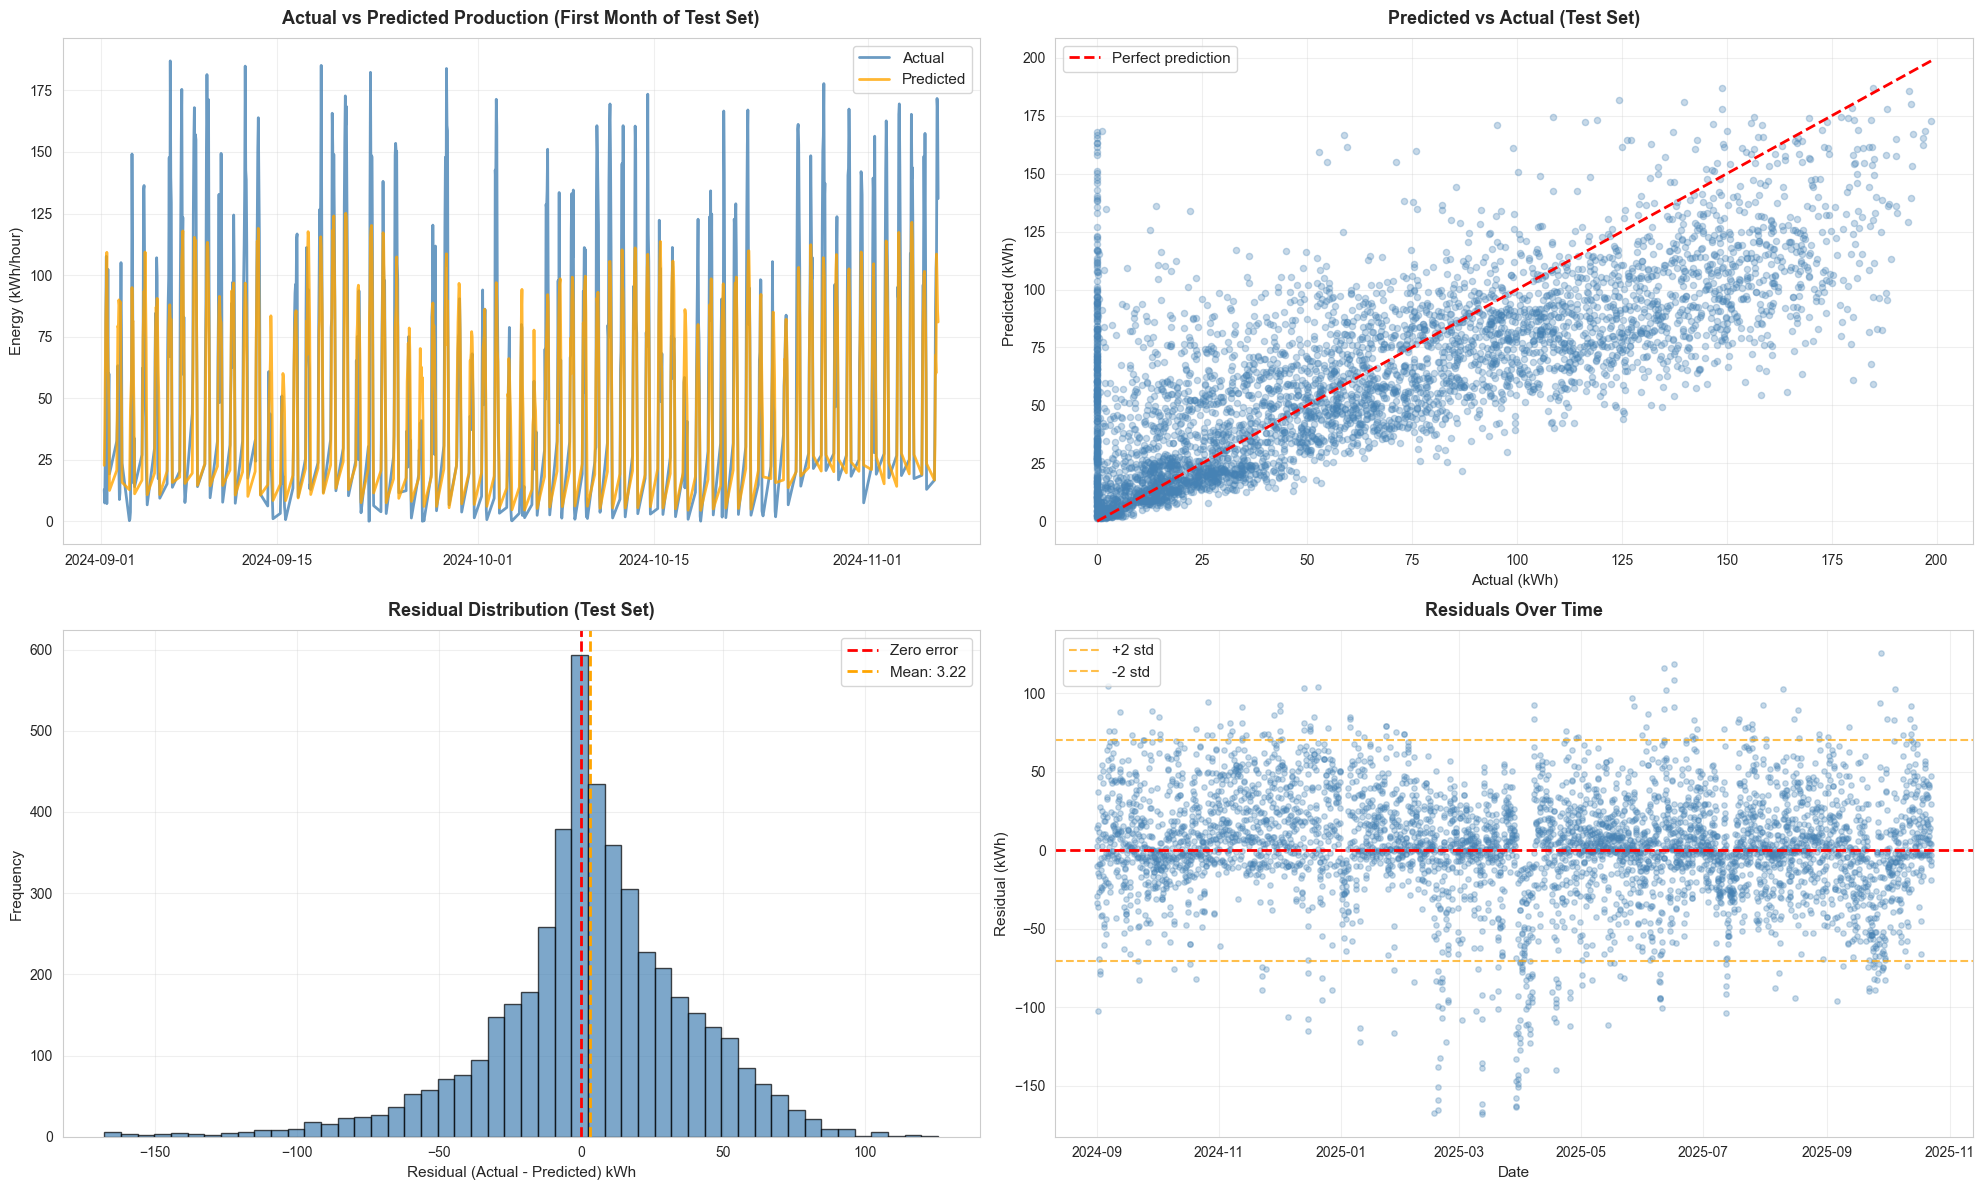

In [8]:
def plot_prediction_analysis(train_df, test_df, y_train_pred, y_test_pred):
    """
    Comprehensive visualization of model predictions.
    """
    # Add predictions to dataframes
    train_df = train_df.copy()
    test_df = test_df.copy()
    train_df['predicted_kwh'] = y_train_pred
    test_df['predicted_kwh'] = y_test_pred

    # Calculate residuals
    train_df['residual'] = train_df['generation_kwh'] - train_df['predicted_kwh']
    test_df['residual'] = test_df['generation_kwh'] - test_df['predicted_kwh']

    # ===== PLOT 1: Actual vs Predicted (Test Set) =====
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))

    # Time series comparison (first month of test set)
    ax1 = axes[0, 0]
    test_sample = test_df.head(720)  # First 30 days
    ax1.plot(test_sample['generation_date'], test_sample['generation_kwh'],
             label='Actual', color='steelblue', linewidth=2, alpha=0.8)
    ax1.plot(test_sample['generation_date'], test_sample['predicted_kwh'],
             label='Predicted', color='orange', linewidth=2, alpha=0.8)
    ax1.set_title('Actual vs Predicted Production (First Month of Test Set)',
                 fontsize=13, fontweight='bold', pad=10)
    ax1.set_ylabel('Energy (kWh/hour)', fontsize=11)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Scatter plot: Predicted vs Actual
    ax2 = axes[0, 1]
    ax2.scatter(test_df['generation_kwh'], test_df['predicted_kwh'],
               alpha=0.3, s=20, color='steelblue')
    max_val = max(test_df['generation_kwh'].max(), test_df['predicted_kwh'].max())
    ax2.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect prediction')
    ax2.set_xlabel('Actual (kWh)', fontsize=11)
    ax2.set_ylabel('Predicted (kWh)', fontsize=11)
    ax2.set_title('Predicted vs Actual (Test Set)', fontsize=13, fontweight='bold', pad=10)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    # Residual distribution
    ax3 = axes[1, 0]
    ax3.hist(test_df['residual'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    ax3.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero error')
    ax3.axvline(test_df['residual'].mean(), color='orange', linestyle='--',
               linewidth=2, label=f'Mean: {test_df["residual"].mean():.2f}')
    ax3.set_xlabel('Residual (Actual - Predicted) kWh', fontsize=11)
    ax3.set_ylabel('Frequency', fontsize=11)
    ax3.set_title('Residual Distribution (Test Set)', fontsize=13, fontweight='bold', pad=10)
    ax3.legend(fontsize=11)
    ax3.grid(True, alpha=0.3)

    # Residual over time
    ax4 = axes[1, 1]
    ax4.scatter(test_df['generation_date'], test_df['residual'],
               alpha=0.3, s=15, color='steelblue')
    ax4.axhline(0, color='red', linestyle='--', linewidth=2)
    ax4.axhline(test_df['residual'].std() * 2, color='orange', linestyle='--',
               linewidth=1.5, alpha=0.7, label='+2 std')
    ax4.axhline(-test_df['residual'].std() * 2, color='orange', linestyle='--',
               linewidth=1.5, alpha=0.7, label='-2 std')
    ax4.set_xlabel('Date', fontsize=11)
    ax4.set_ylabel('Residual (kWh)', fontsize=11)
    ax4.set_title('Residuals Over Time', fontsize=13, fontweight='bold', pad=10)
    ax4.legend(fontsize=11)
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return train_df, test_df

# Plot analysis
train_df_pred, test_df_pred = plot_prediction_analysis(train_df, test_df, y_train_pred, y_test_pred)

---
## Step 5: Anomaly Detection
Flag periods where actual production is significantly below predicted

In [9]:
def detect_production_anomalies(df, threshold_std=2.5):
    """
    Detect anomalies where actual production is significantly below predicted.

    Method:
    - Calculate residual (actual - predicted)
    - Flag when residual < -threshold_std * std(residuals)
    - Only flag negative anomalies (underproduction)
    """
    print("\n🔍 Detecting production anomalies...")

    df = df.copy()

    # Calculate residual statistics
    residual_std = df['residual'].std()
    residual_mean = df['residual'].mean()

    # Define anomaly threshold (negative only - underproduction)
    lower_threshold = residual_mean - threshold_std * residual_std

    # Flag anomalies
    df['is_anomaly'] = df['residual'] < lower_threshold

    # Calculate severity (how many std deviations below expected)
    df['anomaly_severity'] = np.abs((df['residual'] - residual_mean) / residual_std)
    df.loc[~df['is_anomaly'], 'anomaly_severity'] = 0

    # Anomaly statistics
    n_anomalies = df['is_anomaly'].sum()
    pct_anomalies = n_anomalies / len(df) * 100

    print(f"  → Residual mean: {residual_mean:.2f} kWh")
    print(f"  → Residual std: {residual_std:.2f} kWh")
    print(f"  → Anomaly threshold: < {lower_threshold:.2f} kWh")
    print(f"  → Anomalies detected: {n_anomalies:,} ({pct_anomalies:.2f}%)")

    if pct_anomalies < 2:
        print("  → 🟢 Very few anomalies - plant performing well!")
    elif pct_anomalies < 5:
        print("  → 🟡 Some anomalies detected - monitor closely")
    else:
        print("  → 🔴 Many anomalies - investigation recommended")

    return df, lower_threshold, residual_std

# Detect anomalies on test set
test_df_anomaly, anomaly_threshold, residual_std = detect_production_anomalies(
    test_df_pred,
    threshold_std=ML_CONFIG['anomaly_threshold_std']
)


🔍 Detecting production anomalies...
  → Residual mean: 3.22 kWh
  → Residual std: 35.19 kWh
  → Anomaly threshold: < -84.76 kWh
  → Anomalies detected: 92 (1.97%)
  → 🟢 Very few anomalies - plant performing well!


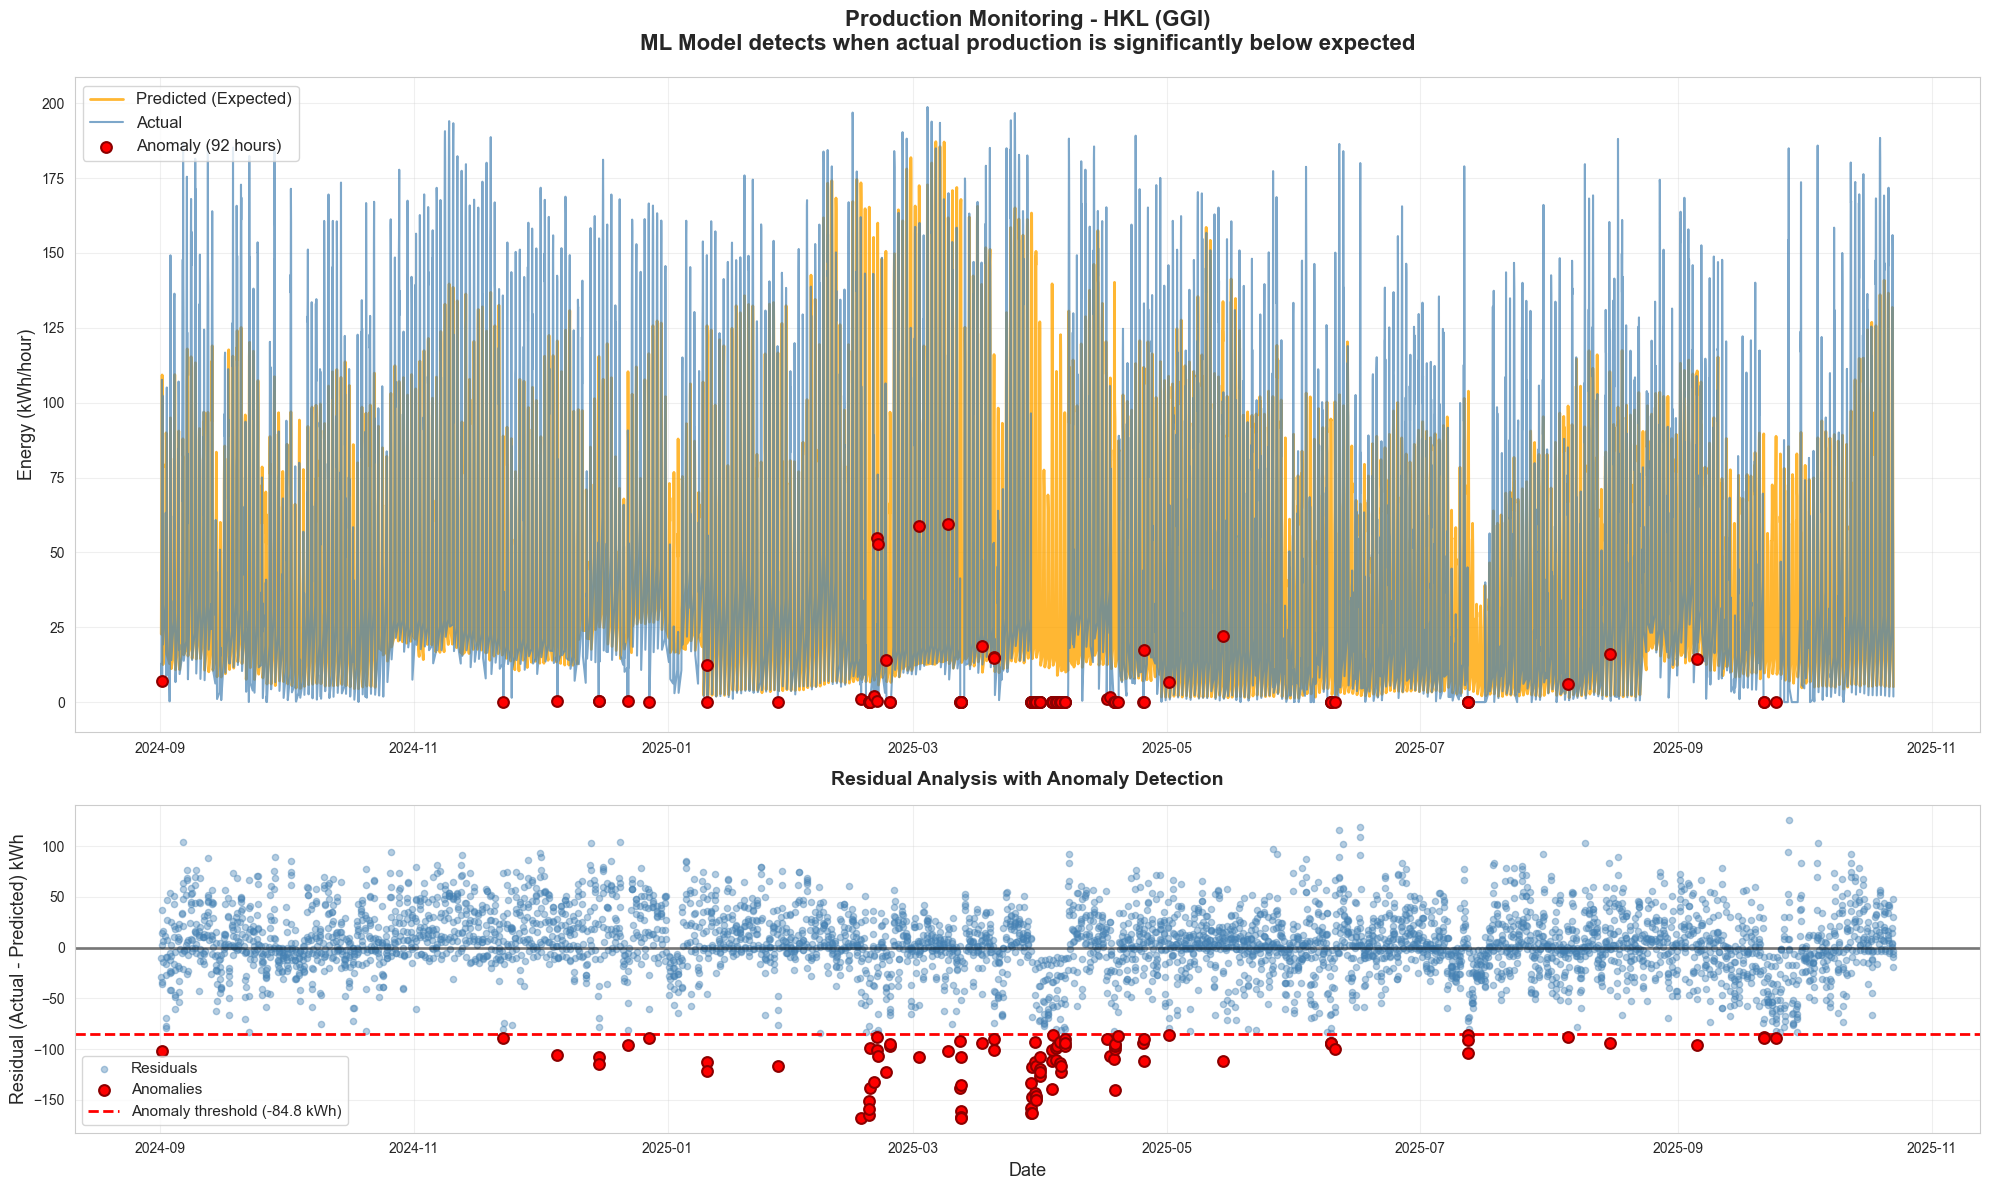

In [10]:
def plot_anomaly_detection(df, anomaly_threshold):
    """
    Visualize detected anomalies.
    """
    fig, axes = plt.subplots(2, 1, figsize=(20, 12), height_ratios=[2, 1])

    # ===== PLOT 1: Production with anomalies =====
    ax1 = axes[0]

    # Plot actual and predicted
    ax1.plot(df['generation_date'], df['predicted_kwh'],
            label='Predicted (Expected)', color='orange', linewidth=2, alpha=0.8)
    ax1.plot(df['generation_date'], df['generation_kwh'],
            label='Actual', color='steelblue', linewidth=1.5, alpha=0.7)

    # Highlight anomalies
    anomalies = df[df['is_anomaly']]
    ax1.scatter(anomalies['generation_date'], anomalies['generation_kwh'],
               color='red', s=60, label=f'Anomaly ({len(anomalies)} hours)',
               zorder=5, edgecolors='darkred', linewidth=1.5)

    ax1.set_title(f'Production Monitoring - {PLANT_CONFIG["name"]}\n'
                 f'ML Model detects when actual production is significantly below expected',
                 fontsize=16, fontweight='bold', pad=20)
    ax1.set_ylabel('Energy (kWh/hour)', fontsize=13)
    ax1.legend(fontsize=12, loc='upper left')
    ax1.grid(True, alpha=0.3)

    # ===== PLOT 2: Residuals with threshold =====
    ax2 = axes[1]

    ax2.scatter(df['generation_date'], df['residual'],
               alpha=0.4, s=20, color='steelblue', label='Residuals')
    ax2.scatter(anomalies['generation_date'], anomalies['residual'],
               color='red', s=60, label='Anomalies', zorder=5,
               edgecolors='darkred', linewidth=1.5)

    ax2.axhline(0, color='black', linestyle='-', linewidth=2, alpha=0.5)
    ax2.axhline(anomaly_threshold, color='red', linestyle='--',
               linewidth=2, label=f'Anomaly threshold ({anomaly_threshold:.1f} kWh)')

    ax2.set_xlabel('Date', fontsize=13)
    ax2.set_ylabel('Residual (Actual - Predicted) kWh', fontsize=13)
    ax2.set_title('Residual Analysis with Anomaly Detection', fontsize=14, fontweight='bold', pad=15)
    ax2.legend(fontsize=11, loc='lower left')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot anomalies
plot_anomaly_detection(test_df_anomaly, anomaly_threshold)

### Anomaly Details
Investigate the worst anomalies

In [11]:
# Show worst anomalies
anomalies = test_df_anomaly[test_df_anomaly['is_anomaly']].copy()
anomalies_sorted = anomalies.sort_values('residual').head(20)

print("\n🚨 Top 20 Worst Anomalies (Largest Underproduction)\n")
print("="*100)

display_cols = [
    'generation_date',
    'generation_kwh',
    'predicted_kwh',
    'residual',
    'temp',
    'clouds_all',
    'ghi',
    'elevation'
]

for idx, row in anomalies_sorted.iterrows():
    print(f"\n📍 {row['generation_date']}")
    print(f"   Actual:    {row['generation_kwh']:6.2f} kWh")
    print(f"   Expected:  {row['predicted_kwh']:6.2f} kWh")
    print(f"   Shortfall: {row['residual']:6.2f} kWh ({row['residual']/row['predicted_kwh']*100:+.1f}%)")
    print(f"   Weather: {row['temp']:.1f}°C, {row['clouds_all']:.0f}% clouds, GHI={row['ghi']:.0f} W/m²")
    print("   " + "-"*70)


🚨 Top 20 Worst Anomalies (Largest Underproduction)


📍 2025-03-12 13:00:00+06:00
   Actual:      0.00 kWh
   Expected:  167.83 kWh
   Shortfall: -167.83 kWh (-100.0%)
   Weather: 31.9°C, 0% clouds, GHI=866 W/m²
   ----------------------------------------------------------------------

📍 2025-02-16 13:00:00+06:00
   Actual:      1.08 kWh
   Expected:  168.59 kWh
   Shortfall: -167.50 kWh (-99.4%)
   Weather: 28.3°C, 0% clouds, GHI=801 W/m²
   ----------------------------------------------------------------------

📍 2025-03-12 12:00:00+06:00
   Actual:      0.00 kWh
   Expected:  166.80 kWh
   Shortfall: -166.80 kWh (-100.0%)
   Weather: 31.5°C, 0% clouds, GHI=892 W/m²
   ----------------------------------------------------------------------

📍 2025-02-18 12:00:00+06:00
   Actual:      0.00 kWh
   Expected:  165.28 kWh
   Shortfall: -165.28 kWh (-100.0%)
   Weather: 27.0°C, 0% clouds, GHI=828 W/m²
   ----------------------------------------------------------------------

📍 2025-03-29 12

---
## Step 6: Daily Monitoring Dashboard
Daily aggregated view for easy monitoring

In [12]:
def create_daily_monitoring_report(df):
    """
    Create daily aggregated report for monitoring.
    """
    print("\n📊 Creating daily monitoring report...")

    # Aggregate to daily
    df_daily = df.groupby(df['generation_date'].dt.date).agg({
        'generation_kwh': 'sum',
        'predicted_kwh': 'sum',
        'residual': 'sum',
        'is_anomaly': 'sum',  # Count anomalous hours per day
        'temp': 'mean',
        'clouds_all': 'mean',
        'rain_1h': 'sum'
    }).reset_index()

    df_daily.columns = [
        'date', 'actual_kwh', 'predicted_kwh', 'daily_residual',
        'anomaly_hours', 'avg_temp', 'avg_clouds', 'total_rain'
    ]

    # Calculate daily metrics
    df_daily['performance_ratio'] = df_daily['actual_kwh'] / df_daily['predicted_kwh']
    df_daily['loss_kwh'] = df_daily['predicted_kwh'] - df_daily['actual_kwh']
    df_daily['loss_pct'] = (1 - df_daily['performance_ratio']) * 100

    # Status flag
    df_daily['status'] = 'Normal'
    df_daily.loc[df_daily['anomaly_hours'] >= 3, 'status'] = 'Attention'
    df_daily.loc[df_daily['anomaly_hours'] >= 6, 'status'] = 'Alert'

    print(f"  ✓ Daily report created for {len(df_daily)} days")

    return df_daily

# Create daily report
daily_report = create_daily_monitoring_report(test_df_anomaly)


📊 Creating daily monitoring report...
  ✓ Daily report created for 417 days


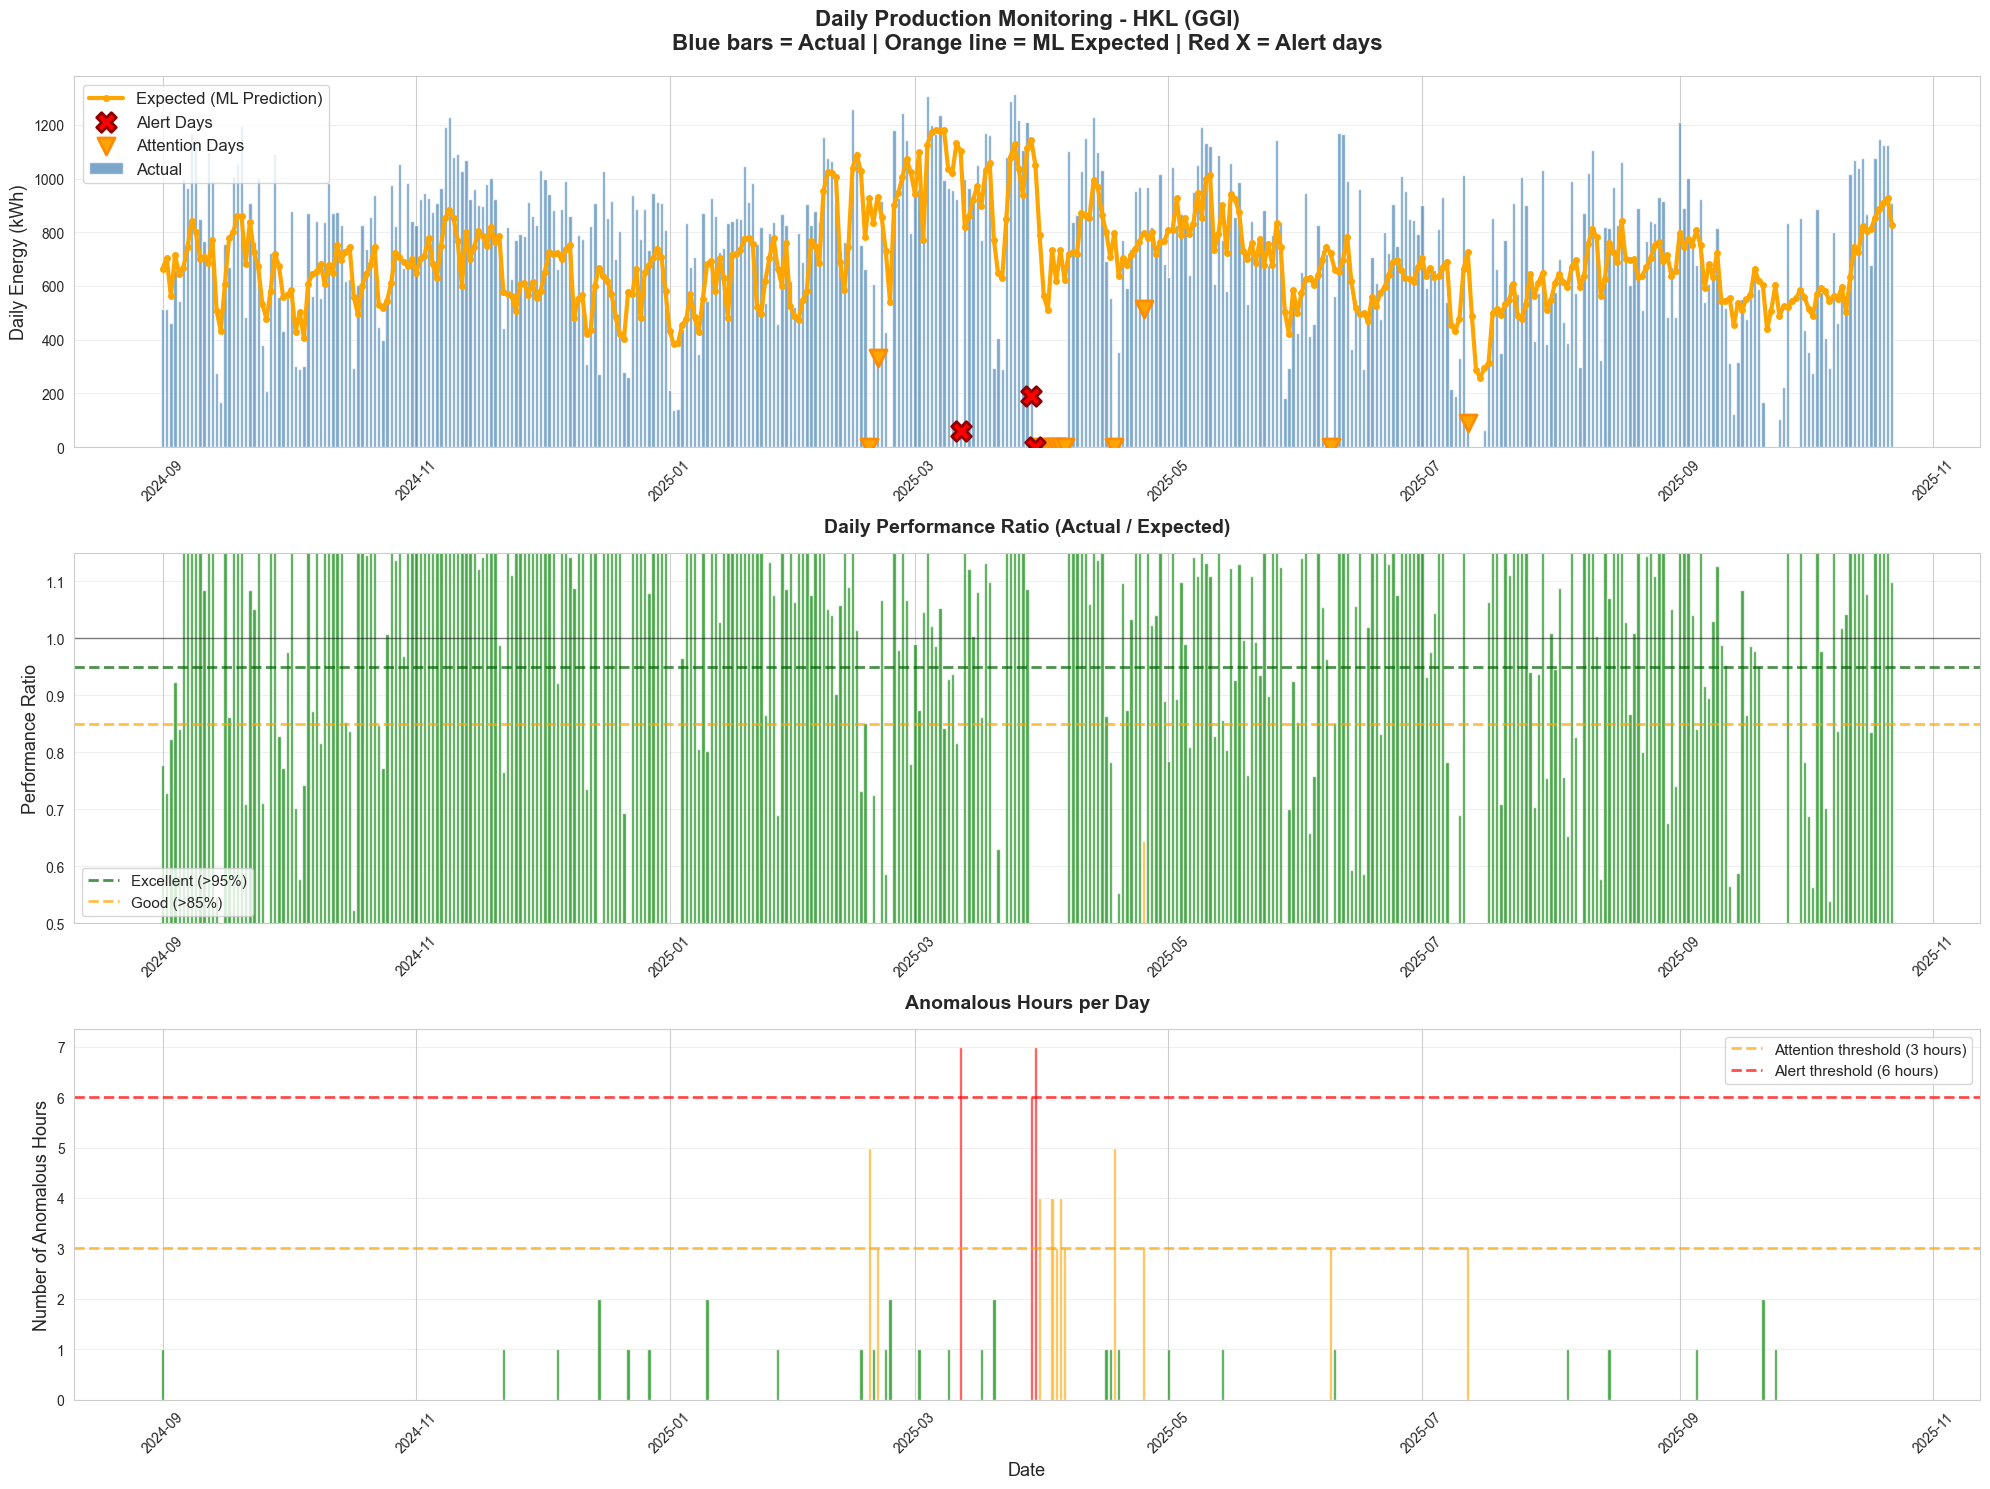

In [13]:
def plot_daily_monitoring_dashboard(df_daily):
    """
    Comprehensive daily monitoring dashboard.
    """
    fig, axes = plt.subplots(3, 1, figsize=(20, 15))

    # ===== PLOT 1: Daily Production =====
    ax1 = axes[0]

    ax1.bar(df_daily['date'], df_daily['actual_kwh'],
           color='steelblue', alpha=0.7, label='Actual', width=0.8)
    ax1.plot(df_daily['date'], df_daily['predicted_kwh'],
            color='orange', linewidth=3, marker='o', markersize=4,
            label='Expected (ML Prediction)')

    # Highlight problem days
    alert_days = df_daily[df_daily['status'] == 'Alert']
    attention_days = df_daily[df_daily['status'] == 'Attention']

    ax1.scatter(alert_days['date'], alert_days['actual_kwh'],
               color='red', s=200, marker='X', label='Alert Days',
               zorder=10, edgecolors='darkred', linewidth=2)
    ax1.scatter(attention_days['date'], attention_days['actual_kwh'],
               color='orange', s=150, marker='v', label='Attention Days',
               zorder=9, edgecolors='darkorange', linewidth=2)

    ax1.set_title(f'Daily Production Monitoring - {PLANT_CONFIG["name"]}\n'
                 f'Blue bars = Actual | Orange line = ML Expected | Red X = Alert days',
                 fontsize=16, fontweight='bold', pad=20)
    ax1.set_ylabel('Daily Energy (kWh)', fontsize=13)
    ax1.legend(fontsize=12, loc='upper left')
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.tick_params(axis='x', rotation=45)

    # ===== PLOT 2: Performance Ratio =====
    ax2 = axes[1]

    colors = df_daily['status'].map({
        'Normal': 'green',
        'Attention': 'orange',
        'Alert': 'red'
    })

    ax2.bar(df_daily['date'], df_daily['performance_ratio'],
           color=colors, alpha=0.7, width=0.8)
    ax2.axhline(y=0.95, color='darkgreen', linestyle='--', linewidth=2,
               alpha=0.7, label='Excellent (>95%)')
    ax2.axhline(y=0.85, color='orange', linestyle='--', linewidth=2,
               alpha=0.7, label='Good (>85%)')
    ax2.axhline(y=1.0, color='black', linestyle='-', linewidth=1, alpha=0.5)

    ax2.set_title('Daily Performance Ratio (Actual / Expected)',
                 fontsize=14, fontweight='bold', pad=15)
    ax2.set_ylabel('Performance Ratio', fontsize=13)
    ax2.set_ylim(0.5, 1.15)
    ax2.legend(fontsize=11, loc='lower left')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.tick_params(axis='x', rotation=45)

    # ===== PLOT 3: Anomaly Hours per Day =====
    ax3 = axes[2]

    ax3.bar(df_daily['date'], df_daily['anomaly_hours'],
           color=colors, alpha=0.7, width=0.8)
    ax3.axhline(y=3, color='orange', linestyle='--', linewidth=2,
               alpha=0.7, label='Attention threshold (3 hours)')
    ax3.axhline(y=6, color='red', linestyle='--', linewidth=2,
               alpha=0.7, label='Alert threshold (6 hours)')

    ax3.set_title('Anomalous Hours per Day', fontsize=14, fontweight='bold', pad=15)
    ax3.set_xlabel('Date', fontsize=13)
    ax3.set_ylabel('Number of Anomalous Hours', fontsize=13)
    ax3.legend(fontsize=11)
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# Plot dashboard
plot_daily_monitoring_dashboard(daily_report)

### Summary Report
Text-based summary for quick review

In [14]:
def print_monitoring_summary(df_daily):
    """
    Print comprehensive monitoring summary.
    """
    print("\n" + "="*80)
    print(f"  DAILY MONITORING SUMMARY - {PLANT_CONFIG['name']}")
    print("="*80)

    # Date range
    print(f"\nPeriod: {df_daily['date'].min()} to {df_daily['date'].max()}")
    print(f"Days analyzed: {len(df_daily)}")

    # Production statistics
    total_actual = df_daily['actual_kwh'].sum()
    total_expected = df_daily['predicted_kwh'].sum()
    total_loss = total_expected - total_actual
    overall_pr = total_actual / total_expected

    print(f"\n⚡ Production Summary:")
    print(f"  Total actual production:   {total_actual:,.0f} kWh")
    print(f"  Total expected production: {total_expected:,.0f} kWh")
    print(f"  Total loss:                {total_loss:,.0f} kWh ({(1-overall_pr)*100:.1f}%)")
    print(f"  Overall Performance Ratio: {overall_pr:.2%}")

    # Daily averages
    avg_daily = df_daily['actual_kwh'].mean()
    best_day = df_daily.loc[df_daily['actual_kwh'].idxmax()]
    worst_day = df_daily.loc[df_daily['actual_kwh'].idxmin()]

    print(f"\n📊 Daily Statistics:")
    print(f"  Average daily production: {avg_daily:,.0f} kWh/day")
    print(f"  Best day:  {best_day['actual_kwh']:,.0f} kWh on {best_day['date']}")
    print(f"  Worst day: {worst_day['actual_kwh']:,.0f} kWh on {worst_day['date']}")

    # Alert summary
    n_normal = (df_daily['status'] == 'Normal').sum()
    n_attention = (df_daily['status'] == 'Attention').sum()
    n_alert = (df_daily['status'] == 'Alert').sum()

    print(f"\n🚦 Status Summary:")
    print(f"  🟢 Normal days:    {n_normal:3d} ({n_normal/len(df_daily)*100:.1f}%)")
    print(f"  🟡 Attention days: {n_attention:3d} ({n_attention/len(df_daily)*100:.1f}%)")
    print(f"  🔴 Alert days:     {n_alert:3d} ({n_alert/len(df_daily)*100:.1f}%)")

    # Overall health
    print(f"\n🏥 Overall Plant Health:")
    if n_alert == 0 and n_attention <= len(df_daily) * 0.1:
        health = "🟢 EXCELLENT - Plant performing as expected"
    elif n_alert <= len(df_daily) * 0.05:
        health = "🟡 GOOD - Minor issues detected, monitor closely"
    elif n_alert <= len(df_daily) * 0.1:
        health = "🟠 FAIR - Several anomalies, investigation recommended"
    else:
        health = "🔴 POOR - Frequent anomalies, immediate attention required"

    print(f"  {health}")

    # Recommendations
    print(f"\n💡 Recommendations:")
    if n_alert > 0:
        print(f"  → Investigate {n_alert} alert days for potential equipment issues")
    if overall_pr < 0.9:
        print(f"  → Overall PR below 90% - check for soiling or shading")
    if df_daily['anomaly_hours'].sum() > len(df_daily) * 0.5:
        print(f"  → High anomaly frequency - consider detailed inverter analysis")
    if n_alert == 0 and n_attention <= 2:
        print(f"  → ✅ Plant operating normally - continue regular monitoring")

    print("\n" + "="*80)

# Print summary
print_monitoring_summary(daily_report)


  DAILY MONITORING SUMMARY - HKL (GGI)

Period: 2024-09-01 to 2025-10-22
Days analyzed: 417

⚡ Production Summary:
  Total actual production:   304,013 kWh
  Total expected production: 288,969 kWh
  Total loss:                -15,044 kWh (-5.2%)
  Overall Performance Ratio: 105.21%

📊 Daily Statistics:
  Average daily production: 729 kWh/day
  Best day:  1,315 kWh on 2025-03-25
  Worst day: 0 kWh on 2025-02-18

🚦 Status Summary:
  🟢 Normal days:    403 (96.6%)
  🟡 Attention days:  11 (2.6%)
  🔴 Alert days:       3 (0.7%)

🏥 Overall Plant Health:
  🟡 GOOD - Minor issues detected, monitor closely

💡 Recommendations:
  → Investigate 3 alert days for potential equipment issues



---
## Step 7: Export Results
Save model and results for production use

In [15]:
import pickle
import os

# Create output directory
os.makedirs('output', exist_ok=True)

# Save model
with open('output/production_model.pkl', 'wb') as f:
    pickle.dump(model, f)
print("✓ Model saved to output/production_model.pkl")

# Save feature list
with open('output/feature_columns.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)
print("✓ Feature list saved")

# Save daily report
daily_report.to_csv('output/daily_monitoring_report.csv', index=False)
print("✓ Daily report saved to output/daily_monitoring_report.csv")

# Save hourly predictions
test_df_anomaly.to_csv('output/hourly_predictions_with_anomalies.csv', index=False)
print("✓ Hourly data saved to output/hourly_predictions_with_anomalies.csv")

# Save alert days list
alert_days = daily_report[daily_report['status'].isin(['Alert', 'Attention'])]
alert_days.to_csv('output/alert_days.csv', index=False)
print(f"✓ Alert days saved ({len(alert_days)} days)")

print("\n✅ All results exported to output/ directory")

✓ Model saved to output/production_model.pkl
✓ Feature list saved
✓ Daily report saved to output/daily_monitoring_report.csv
✓ Hourly data saved to output/hourly_predictions_with_anomalies.csv
✓ Alert days saved (14 days)

✅ All results exported to output/ directory


---
## How to Use This System for Daily Monitoring

### 1. **Initial Setup** (Done above)
- Train model on historical data
- Validate performance
- Save model to disk

### 2. **Daily Monitoring Workflow**
```python
# Load new day's data
new_data = load_todays_data()  # Your data loading function

# Load trained model
with open('output/production_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Predict expected production
expected = model.predict(new_data[feature_cols])

# Compare to actual
actual = new_data['generation_kwh']
residual = actual - expected

# Flag anomalies
if residual < anomaly_threshold:
    send_alert("Production below expected!")
```

### 3. **Weekly Review**
- Review alert days
- Check for trending issues
- Update model if plant conditions change

### 4. **Monthly Re-training**
- Retrain model with latest data
- Captures seasonal changes and gradual degradation
- Improves prediction accuracy over time